
<center>

# **PREDICTIVE METHOD:** 
# **RANDOM FOREST CLASSIFIER - WITH DIMENSIONALITY REDUCTION** 
by: Ly Nguyen

<center>

In [4]:
# Import necessary libraries for this notebook: 

# Read from SQLite database and load to a pandas dataframe
import os
import sqlite3
import pandas as pd

# For using arrays 
import numpy as np

# For ML work (data preprocessing, hyperparameter tuning, Random Forest Classifier, training & testing sets, and stratified sampling)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# For model evaluation, including explainability:  
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import statsmodels.api as sm
import shap

# For data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# For saving the model into a pkl file
import joblib


In [5]:
# Define the base directory for the files
base_dir = os.path.join("..", "data")

# Define file paths
file_paths = {
    "df_cleaned": "df_cleaned.parquet",
    "X_train": "X_train.parquet",
    "y_train": "y_train.csv",
    "X_test": "X_test.parquet",
    "y_test": "y_test.csv",
    "top_50_features": "top_50_features.csv"
}

# Load files
df_cleaned = pd.read_parquet(os.path.join(base_dir, file_paths["df_cleaned"]))
X_train = pd.read_parquet(os.path.join(base_dir, file_paths["X_train"]))
y_train = pd.read_csv(os.path.join(base_dir, file_paths["y_train"]))
X_test = pd.read_parquet(os.path.join(base_dir, file_paths["X_test"]))
y_test = pd.read_csv(os.path.join(base_dir, file_paths["y_test"]))
top_50_features = pd.read_csv(os.path.join(base_dir, file_paths["top_50_features"]))


REMOVE OVER 4,000 FEATURES TO ONLY KEEP TOP 50 FEATURES FOR X, AND RE-FIT MODEL.

In [6]:
# Extract top 50 features list to feed to "X_new"
top_features_list = top_50_features['Feature'].tolist()

# Create new X and y based on reduced features
X_new = df_cleaned[top_features_list]
y_new = df_cleaned['delayType']  # Target variable

# Split data into training and test sets with stratification
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_new, y_new, test_size=0.3, stratify=y_new, random_state=42
)


In [25]:
# Save the training set parquet file in 'data' folder (for other ML experimentations)
relative_path = os.path.join("..", "data", "X_train_new.parquet")
X_train_new.to_parquet(relative_path, index=False)

relative_path = os.path.join("..", "data", "y_train_new.csv")
y_train_new.to_csv(relative_path, index=False)


# Save the test set parquet file in 'data' folder (for other ML experimentations)
relative_path = os.path.join("..", "data", "X_test_new.parquet")
X_test_new.to_parquet(relative_path, index=False)

relative_path = os.path.join("..", "data", "y_test_new.csv")
y_test_new.to_csv(relative_path, index=False)

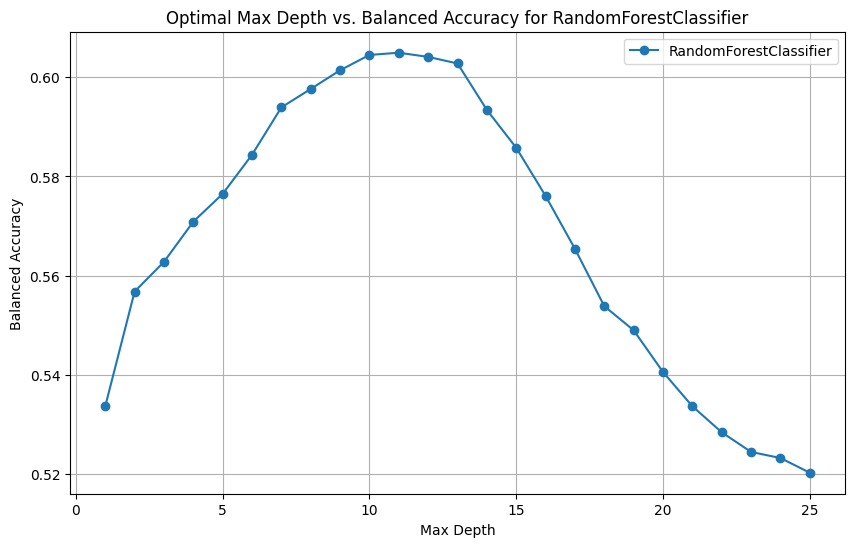

In [8]:
# Set up stratified cross-validation on the training set
stratified_cv_new = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the range for max_depth
max_depth_range_new = range(1, 26)
balanced_accuracy_depth_new = []

# Tune max_depth using stratified cross-validation
for max_depth in max_depth_range_new:
    rf_temp_new = RandomForestClassifier(max_depth=max_depth, class_weight='balanced', random_state=42)
    # Perform cross-validation with balanced accuracy scoring
    scores_new = cross_val_score(rf_temp_new, X_train_new, y_train_new, cv=stratified_cv_new, scoring='balanced_accuracy')
    mean_score_new = scores_new.mean()
    balanced_accuracy_depth_new.append(mean_score_new)

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range_new, balanced_accuracy_depth_new, label="RandomForestClassifier", marker='o')
plt.title("Optimal Max Depth vs. Balanced Accuracy for RandomForestClassifier")
plt.xlabel("Max Depth")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.grid(True)  # Adds a grid for better readability
plt.show()


*Observation:* 
- Optimal Max Depth is about 10 to 12.

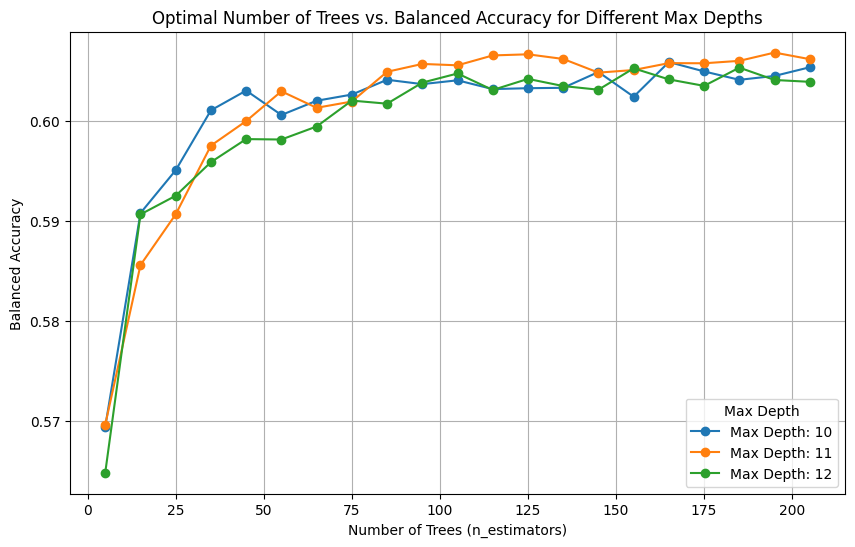

In [10]:
# Define the ranges for hyperparameters
max_depth_range_new = [10, 11, 12]  # Limited max_depth range for faster tuning
n_estimators_range_new = range(5, 210, 10)  # Range for n_estimators

# Initialize Stratified K-Fold and storage for results
stratified_cv_new = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_new = []  # To store results for each combination

# Perform grid search for max_depth and n_estimators
for max_depth in max_depth_range_new:
    balanced_accuracy_scores_new = []
    for n_estimators in n_estimators_range_new:
        rf_temp_new = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight='balanced',
            random_state=42
        )
        # Perform cross-validation with balanced accuracy scoring
        scores_new = cross_val_score(
            rf_temp_new, X_train_new, y_train_new, cv=stratified_cv_new, scoring='balanced_accuracy'
        )
        mean_score_new = scores_new.mean()
        balanced_accuracy_scores_new.append(mean_score_new)
    
    # Store results for this max_depth
    results_new.append((max_depth, balanced_accuracy_scores_new))

# Plot the results for each max_depth
plt.figure(figsize=(10, 6))
for max_depth, scores_new in results_new:
    plt.plot(
        n_estimators_range_new,
        scores_new,
        label=f"Max Depth: {max_depth}",
        marker='o'
    )

plt.title("Optimal Number of Trees vs. Balanced Accuracy for Different Max Depths")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Balanced Accuracy")
plt.legend(title="Max Depth")
plt.grid(True)  # Adds grid for better readability
plt.show()


*Observation:*
- Optimal max-depth is 11. 
- Optimal number of trees is about 125 trees, after which the incremental benefit is negligible.

In [11]:
# Define the parameter grid with max_depth fixed at 11
param_grid_new = {
    'n_estimators': [110, 125, 140],  # Number of trees in the forest
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest Classifier with fixed max_depth
clf_new = RandomForestClassifier(max_depth=11, class_weight='balanced', random_state=42)

# Initialize StratifiedKFold for stratified cross-validation
stratified_cv_new = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with StratifiedKFold
grid_search_new = GridSearchCV(
    estimator=clf_new,
    param_grid=param_grid_new,
    cv=stratified_cv_new,
    scoring='balanced_accuracy',
    n_jobs=-1  # Use all available processors
)

# Fit GridSearchCV to the data
grid_search_new.fit(X_train_new, y_train_new)

# Print the best parameters and score
print("Best parameters found: ", grid_search_new.best_params_)


Best parameters found:  {'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 140}


In [12]:
# Define the best parameters found from GridSearchCV
best_params_new = {
    'min_samples_leaf': 2,  # Minimum number of samples required to be at a leaf node
    'min_samples_split': 10,  # Minimum number of samples required to split an internal node
    'n_estimators': 140,  # Number of trees in the forest
    'max_depth': 11  # Maximum depth of the tree
}

# Initialize and fit the Random Forest Classifier with the best parameters
best_clf_new = RandomForestClassifier(**best_params_new, class_weight='balanced', random_state=42)
best_clf_new.fit(X_train_new, y_train_new)


RandomForestClassifier(class_weight='balanced', max_depth=11,
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=140, random_state=42)

In [13]:
# Fit the model to the test set
y_pred_new = best_clf_new.predict(X_test_new)


In [14]:
# Get the feature importances from the trained Random Forest model
feature_importances_new = best_clf_new.feature_importances_

# Use the feature names from the preprocessed data
features_new = X_new.columns  # Get all the feature names from the DataFrame after preprocessing

# Create a DataFrame for feature importances
importance_df_new = pd.DataFrame({'Feature': features_new, 'Importance': feature_importances_new})

# Sort the DataFrame by importance in descending order
importance_df_new = importance_df_new.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df_new)


                              Feature  Importance
1                  incident_Diversion    0.187993
0                            line_512    0.135414
2                 incident_Mechanical    0.070699
3                            line_506    0.047415
16             seasonType_Summer 2024    0.039815
5                            line_505    0.034271
11             seasonType_Spring 2023    0.030824
4   incident_Collision - TTC Involved    0.028623
12                           line_510    0.027599
10        incident_Emergency Services    0.026359
7                 incident_Operations    0.025999
6                  day_of_week_Sunday    0.025617
9              incident_General Delay    0.023321
14                   incident_Held By    0.021490
8         incident_Utilized Off Route    0.016480
20                           line_501    0.016272
24             seasonType_Winter 2023    0.015128
19             seasonType_Winter 2024    0.014378
29                            bound_W    0.014124


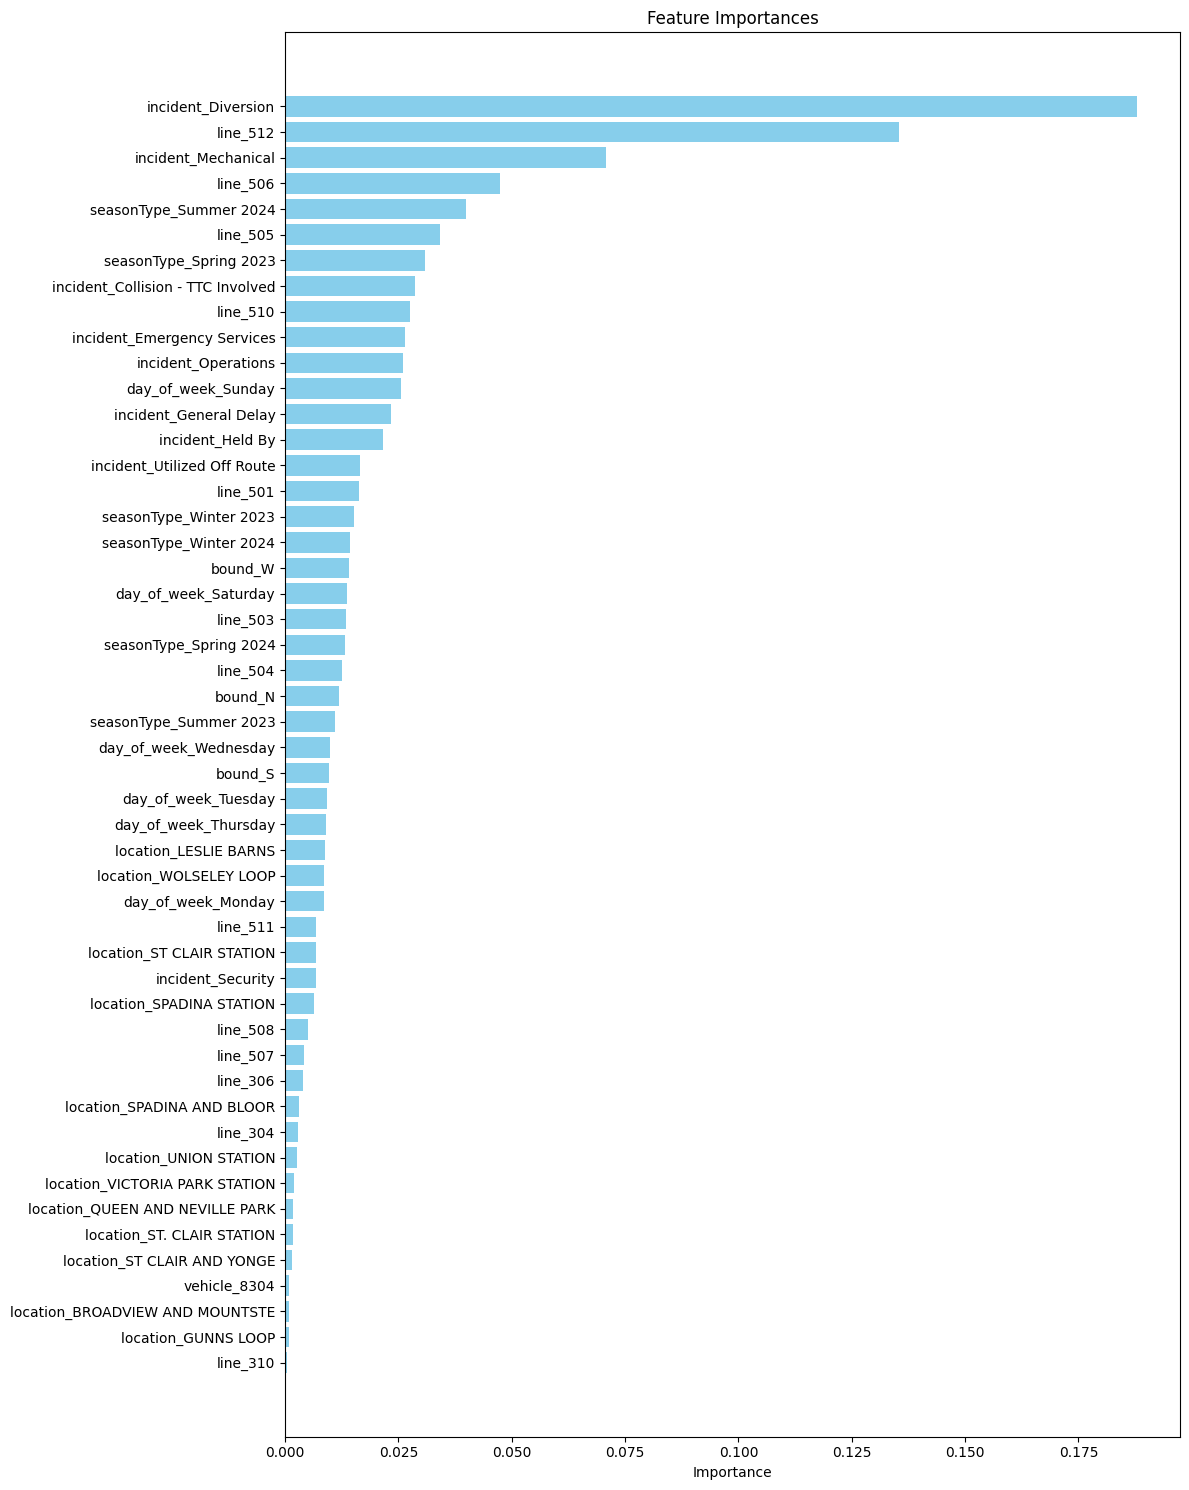

In [15]:
# Plot all feature importances
plt.figure(figsize=(12, 15))  # Adjust the figure size to accommodate all features
plt.barh(
    importance_df_new['Feature'][::-1],  # Reverse the order for the bar plot
    importance_df_new['Importance'][::-1],
    color='skyblue'
)
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()  # Adjust layout to avoid clipping
plt.show()


In [16]:
# Generate the classification report
class_report_new = classification_report(y_test_new, y_pred_new)
print("Classification Report:\n", class_report_new)

# Calculate and print the balanced accuracy score
balanced_acc_new = balanced_accuracy_score(y_test_new, y_pred_new)
print(f"\nBalanced Accuracy: {balanced_acc_new:.2f}")



Classification Report:
               precision    recall  f1-score   support

           1       0.34      0.63      0.44       583
           2       0.83      0.62      0.71      3832
           3       0.42      0.61      0.49      1056

    accuracy                           0.62      5471
   macro avg       0.53      0.62      0.55      5471
weighted avg       0.70      0.62      0.64      5471


Balanced Accuracy: 0.62


### **INTERPRETATION:**

- **Balanced Accuracy** and **Accuracy**: 

    - The new model performs 2% better than the previous model (62% vs 60%). 
    - The new model performs above average, with **62%** of the predictions made by the model are correct. 

- **Precision, Recall, and F1-score (ie. the harmonic mean of precision and recall):** 
    

    - **Precision scores**: 
    
        - The new model performs 5% better for Delay Type 3 (42% vs 37%) than the previous model
        - Good score for the majority class (Delay Type 2 - normal delay) at 83%, meaning there are very few false positive for the normal delay class. 
        - Poor score (many false positives) for the minority classes (Delay Type 1 and 3, at 34% and 42% respectively)


    - **Recall scores**: 
    
        - Overall the new model performs better than the previous model:

            - 2% improvement for Delay Type 1 (63% vs 61%) 
            - 6% improvement for Delay Type 2 (62% vs 56%)
            - 2% worse for Delay Type 3 (61% vs 63%)
        
        - However, there are still many missed true positive cases, although, it does perform above average.  

       
    - **F1 scores**: 
        
        - Overall the new model performs better than the previous model:

            - 1% improvement for Delay Type 1 (44% vs 43%) 
            - 4% improvement for Delay Type 2 (71% vs 67%)
            - 3% improvement for Delay Type 3 (49% vs 46%)
        
        - This means that the model is not effective at correctly identifying positive instances while minimizing false positives for the minority classes, but performs acceptably for the majority class (normal delays)


### **CONCLUSION:**

- Reducing dimensions (from > 4,300 features to 50 features) overall improvese performance across scoring metrics.
- The new model performs very well at 'precision score' for the majority class (83% for Delay Type 2 - normal delays), meaning there are very few false positives for normal delay type. 
- The new model performs above average at 'recall score' across the classes (average 62%), meaning it performs above average at identifying true positive cases for each delay type.
- The new model performs acceptably at 'F1 score' for the majority class (71% for Delay Type 2 - normal delay type), meaning it performs acceptably at identifying positive instancees while minimizing false positives for this class. 



In [17]:
# SHAP explainer
explainer_new = shap.TreeExplainer(best_clf_new)

shap_values_new = explainer_new.shap_values(X_test_new)


In [18]:
# SHAP values for delayType = 1
shap_values_class1_new = shap_values_new[0]

# SHAP values for delayType = 2
shap_values_class2_new = shap_values_new[1]

# SHAP values for delayType = 3
shap_values_class3_new = shap_values_new[2]

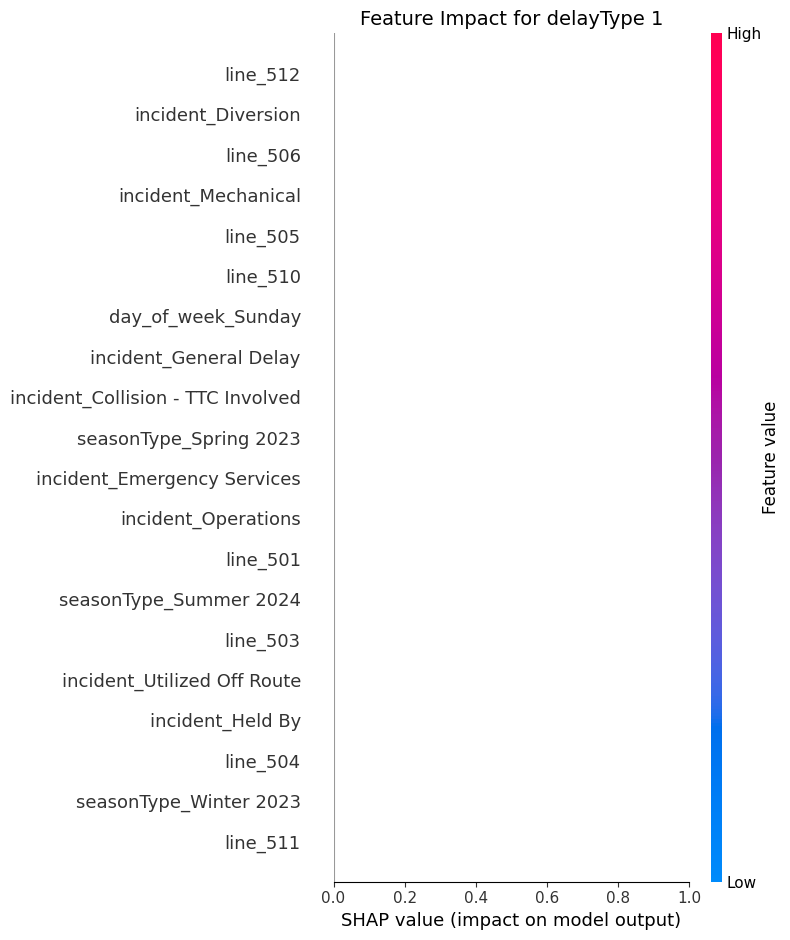

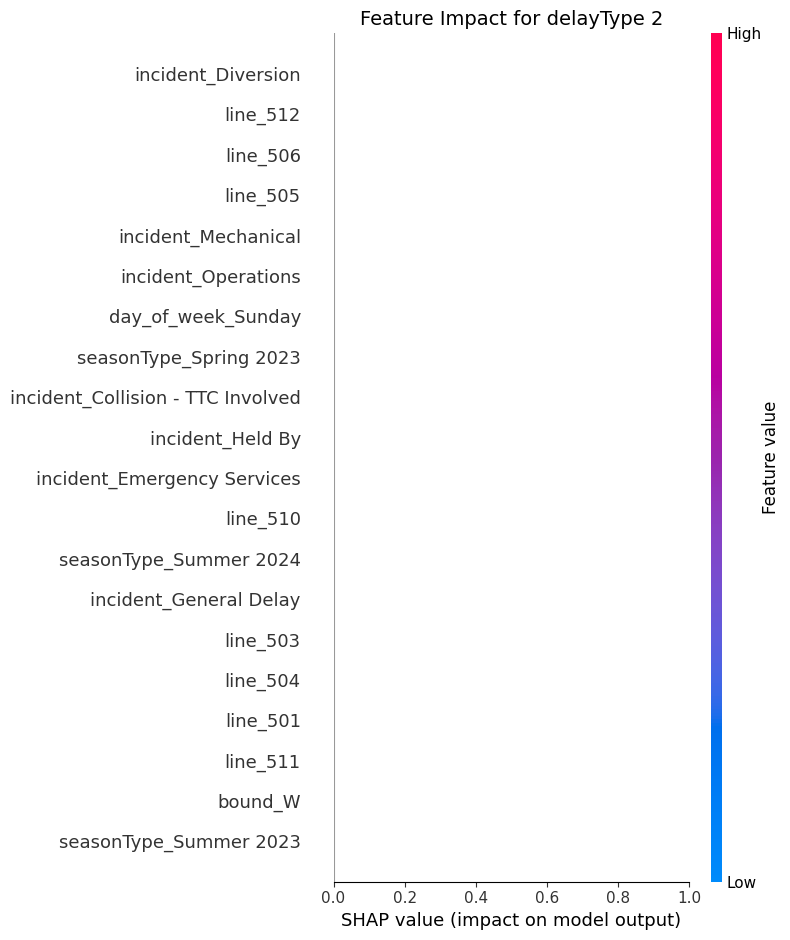

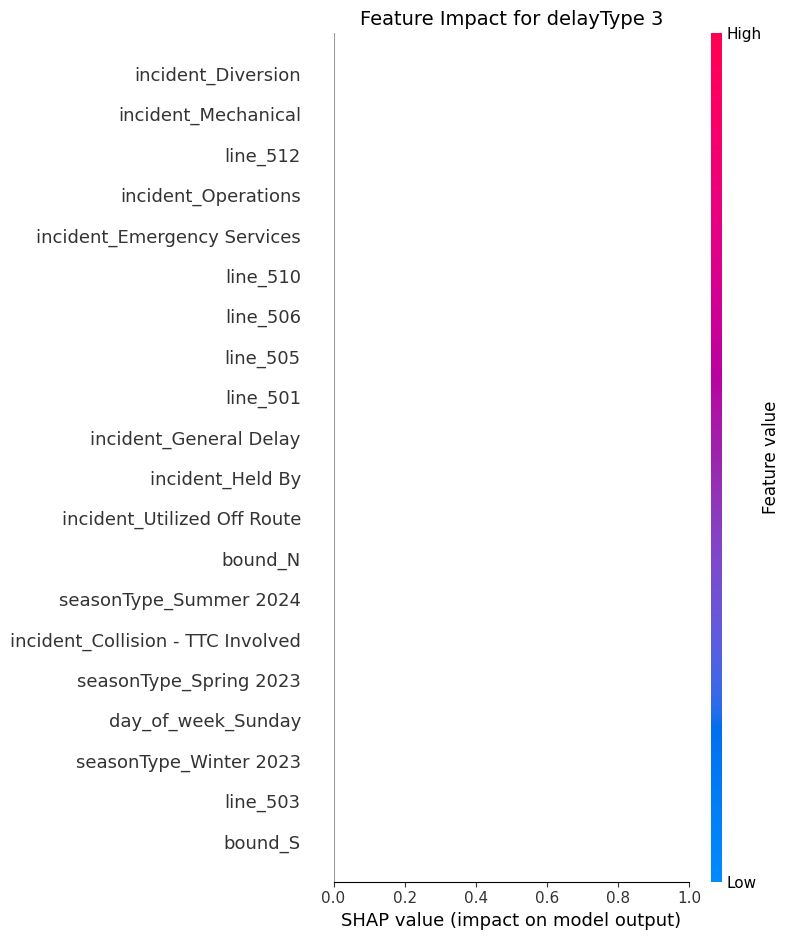

In [19]:
# Define SHAP values and class labels
shap_values_classes = [shap_values_class1_new, shap_values_class2_new, shap_values_class3_new]
class_labels = ["delayType 1", "delayType 2", "delayType 3"]

# Generate beeswarm plots dynamically
plt.close('all')
for shap_values_class, label in zip(shap_values_classes, class_labels):
    plt.figure(figsize=(8, 6))
    shap.summary_plot(
        shap_values_class, 
        X_test_new, 
        plot_type="beeswarm", 
        show=False
    )
    plt.gca().set_title(f"Feature Impact for {label}", fontsize=14)
    plt.tight_layout()
    plt.show()


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


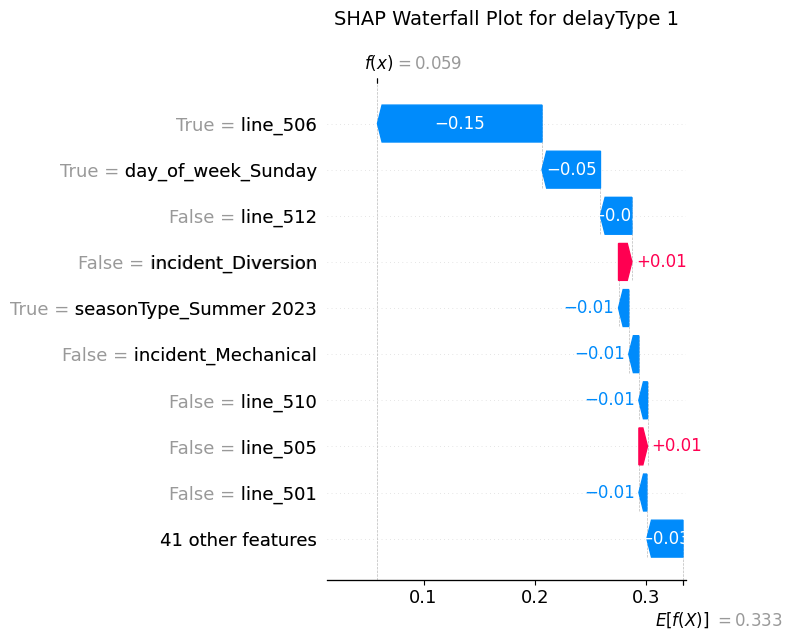

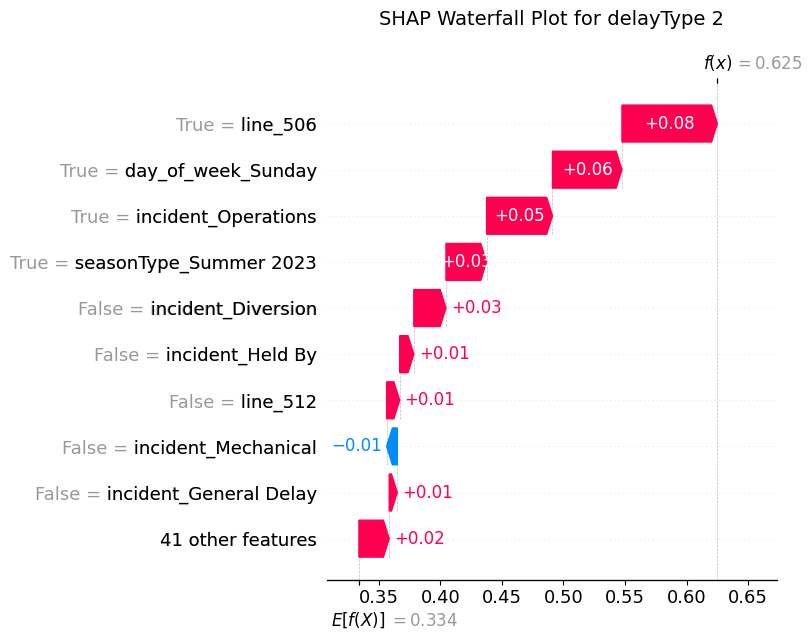

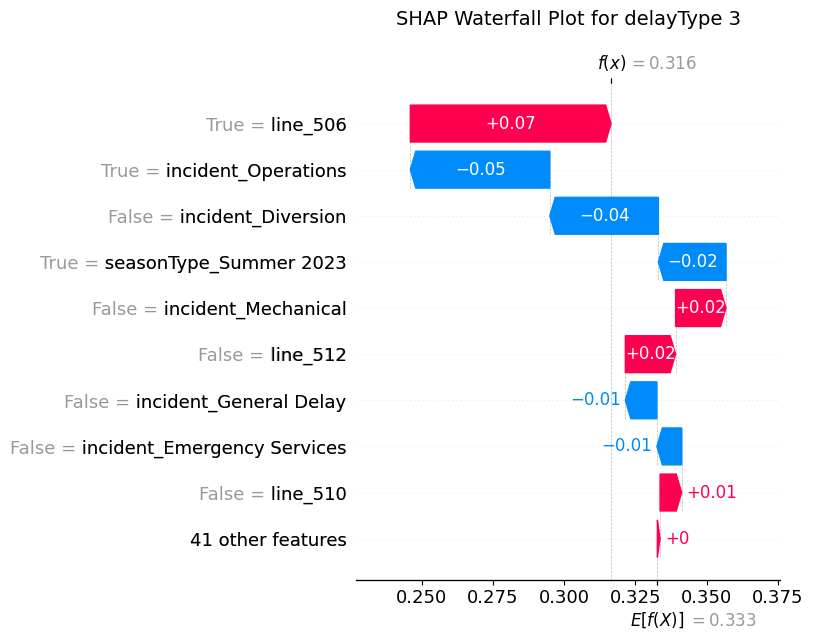

In [20]:
# Sample index for demonstration
sample_index_new = 0

# Store them in a list of arrays
shap_values_list_new = [shap_values_class1_new, shap_values_class2_new, shap_values_class3_new]

# Iterate through each class to create waterfall plots
for i, shap_values_class in enumerate(shap_values_list_new):
    # Create SHAP explanation object for the current class
    explanation_new = shap.Explanation(
        values=shap_values_class[sample_index_new],
        base_values=explainer_new.expected_value[i],  # Base value for the current class
        data=X_test_new.iloc[sample_index_new],
        feature_names=X_test_new.columns
    )
    
    # Generate the waterfall plot with a title directly inside the plot
    plt.figure(figsize=(8, 6))  # Set figure size
    shap.waterfall_plot(explanation_new, max_display=10, show=False)
    plt.title(f"SHAP Waterfall Plot for delayType {i+1}", fontsize=14, pad=20)  # Add a title to the plot
    plt.tight_layout()  # Tight layout
    plt.show()  # Display the plot


*Observation:*

- [To be filled in by XiaoXiao / Shruti / Namreen]

# Saving files for App Deployment

In [26]:
# Save the trained model to a pkl file in 'data' folder
relative_path = os.path.join("..", "data", "RF.pkl")
joblib.dump(best_clf_new, relative_path) 




['..\\data\\RF.pkl']

In [23]:
# Cleaning feature names for app deployment
def assign_category(feature):
    if "day_of_week_" in feature:
        return "Day of Week"
    elif "line_" in feature:
        return "Line"
    elif "seasonType_" in feature:
        return "Season"
    elif "timeType_" in feature:
        return "Time Type"
    elif "incident_" in feature:
        return "Incident Type"
    elif "location_" in feature:
        return "Location"
    elif "bound_" in feature:
        return "Bound"
    else:
        return "Other"


In [24]:
# Extract top 50 features and create a new DataFrame
top50_new_rf = importance_df_new.head(50).copy()

# Assign categories
top50_new_rf['Category'] = top50_new_rf['Feature'].apply(assign_category)

# Save as csv file in 'data' folder
relative_path = os.path.join("..", "data", "top50_new_rf.csv")
top50_new_rf.to_csv(relative_path, index=False)



---
---